<center><h1>Assignment 4</h1></center>

In [76]:
# install.packages("gamair")
library(gamair)
# install.packages('lubridate')
library(lubridate)
# install.packages('msm')
library(msm)

1. Read the two pages from [Wood (2006)](https://www.dropbox.com/s/g2q2l9lk5w1ccdk/Wood_2006.pdf?dl=1). Using the Hubble data (see code below), answer the following questions.

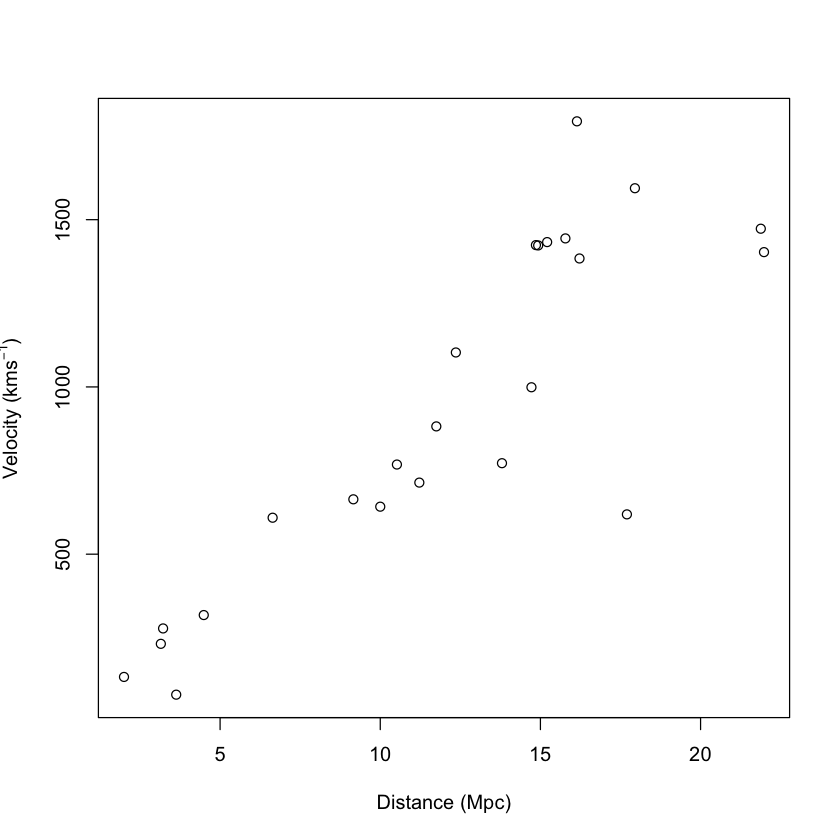

In [66]:
data(hubble)

# Figure 1.1 from Wood 2006
plot(hubble$x,hubble$y,xlab="Distance (Mpc)",
     ylab=expression("Velocity (km"*s^{-1}*")"))

(a) Fit a linear model that corresponds to Hubble's Law. Estimate all parameter(s) using maximum likelihood estimation. Please show all relevant R code.

$y_i = \beta x_i + \epsilon_i$

In [ ]:
# 1.
# a.
# y_i = \betax_i + \epsilon_i

x <- hubble$x
y <- hubble$y
n <- length(y)

X <- matrix(data = cbind(rep(1, length(x)), x), nrow = length(x), byrow = FALSE)

beta <- solve(t(X) %*% X) %*% t(X) %*% y

sigma2 <- (1 / n) * t(y - X %*% beta) %*% (y - X %*% beta)
sigma2

# Double check with stats software
ml1 <- lm(y ~ x-1, data = hubble)
beta <- coef(ml1)

summary(ml1)$sigma^2  # FIXME: not the same as sigma2

64244.56


[1] 67046.33

(b) Using the parameter estimates from part a, what is the most likely age of the universe in years? Note that distance is measured in Mega parsecs. A Mega parsecs is $3.09x10^{19}$ km.

In [68]:
# b.
mega_parsecs <- 3.09 * (10^19)  # in km

(1 / beta) * mega_parsecs   # Age of the universe

distance <- beta / mega_parsecs
age <- 1 / distance  # in years
age

x 
4.034934e+17

x 
4.034934e+17

(c) Calculate a 95% confidence interval for the estimated age from part b.

In [ ]:
# c.
coef(ml1)

interval <- confint(ml1, level=0.95)
interval

x 
76.58117

,2.5 %,97.5 %
x,68.37937,84.78297


(d) Explain how to interpret the 95% confidence interval from part c.
- There is a 95% that the interval covers the estimate.

2. In the R code below, I provide a data set that I obtained from the National Oceanic and Atmospheric Administration (NOAA). The documentation is available here [(link)](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf). Please write a short 4-5 sentence description of the data (e.g., Where were the data collected? What is being measured?).
   
The Global Historical Climatology Network (GHCN) database serves as the primary data source for this analysis. This database aggregates climate data from 40 meteorological elements, including precipitation, snow depth, daily temperature (maximum and minimum), wind speed, and movement. The data was collected through the cooperation of over 100,000 stations worldwide, making it one of the largest climatological datasets available. The provided R code dataset consists of the following columns:

- STATION
- NAME
- DATE
- TMAX (Maximum daily temperature)
- TMIN (Minimum daily temperature)
- TOBS (Temperature at the time of observation)

Notably, this dataset contains a subset of 47,410 observations from a single location in Manhattan, Kansas, spanning the period from 1893 to 2023.

3. I have always wondered if the temperature in Manhattan has increased over a long time period (i.e., perhaps a local effect of global climate change). Write out a linear model that enables you to determine if the temperature has increased over a long time period. Make sure to explain each component of your linear model and include distributional assumptions (e.g., $\epsilon_i \sim N(0, \sigma^2)$).

- $y_i = \beta_0 + \beta_1t_i + \epsilon_i$
    Where:
    - $y_i$ is the observed temperature at time $t_i$
    - $t_i$ is the time of the observation $i$
    - $\beta_0$ is the intercept of the baseline observed temperature
    - $\beta_1$ is the slope of the change in temperature per unit of time
    - $\epsilon_i$ is the random error term for the observation $i$
- Error terms follow normal distribution $\epsilon_i \sim N(0, \sigma^2)$


In [77]:
url <- "https://www.dropbox.com/s/asw6gtq7pp1h0bx/manhattan_temp_data.csv?dl=1"
df.temp <- read.csv(url)
df.temp$year = as.numeric(year(df.temp$DATE))
df.temp$DATE <- ymd(df.temp$DATE)
df.temp$days <- df.temp$DATE - min(df.temp$DATE)

# Cleanup: remove rows with NA TOBS values
df.temp = subset(df.temp, !is.na(TOBS))

4. For the linear model you wrote out in question 3, estimate and quantify uncertainty for the parameters by fitting this model to the data from question 2. Please write 3-5 sentences explaining your estimates.

In [83]:
# Quantify uncertainty for parameters
model <- lm(TOBS ~ days, data=df.temp)

confint(model, level=0.95)

beta0.hat <- as.numeric(coef(model)[1])
beta0.hat
beta1.hat <- as.numeric(coef(model)[2])
beta1.hat

temp.hat <- beta0.hat / beta1.hat
temp.hat

,2.5 %,97.5 %
(Intercept),4.565221e+01,47.207439239
days,1.663215e-04,0.000214247


[1] 46.42983

[1] 0.0001902842

[1] 244002.5

In [ ]:
temp.se <- deltamethod(~ x1/x2, mean=coef(model), cov=vcov(model))
temp.ci <- c(
  (temp.hat - 1.96 * temp.se),
  (temp.hat + 1.96 * temp.se)
)
temp.ci

x <- as.numeric(df.temp$days)
x.bar <- mean(x)
y <- df.temp$TOBS
y.bar <- mean(y)

[1] 209369.6 278635.3

The estimates intercept and days were estimated to be at $46.4298$ and $0.0001$
respectively. When using the 95% confidence interval, both intervals cover the estimates:


| Coef. | 2.5 %	| 97.5 % |
| ----  | ----- | ------ |
| (Intercept) |	4.565221e+01 | 47.207439239 |
| days |	1.663215e-04 |	0.000214247 |

This means that the population estimates will be covered in the interval 95% of the time. When using the delta method, the confidence interval $[209369.6401, 278635.3418]$ covers the estimate $244002.4910$.


5. Using the idea of probabilistic thinking and the linear model you used in question 4, predict the temperature for January 1, 2050. Please write 3-5 sentences explaining your prediction.

In [73]:
# Squared distance (with optimization)
sqrd_dist <- optim(
  par = c(0, 0),
  method = c("Nelder-Mead"),
  fn = function(beta) {
    sum((y - (beta[1] + beta[2] * x))^2)
  }
)
sqrd_dist

sqrd_dist_para_1 <- sqrd_dist[1]$par[1]
sqrd_dist_para_2 <- sqrd_dist[1]$par[2]

$par
[1] 4.643207e+01 1.902857e-04

$value
[1] 16241465

$counts
function gradient 
     101       NA 

$convergence
[1] 0

$message
NULL

In [74]:
# Calculate days since start
start_date <- min(ymd(df.temp$DATE))
target_date <- as.Date("2050-01-01")
x_2050 <- as.numeric(target_date - start_date)

# squared distance Prediction
tobs_pred_sqrd_dist <- sqrd_dist_para_1 + sqrd_dist_para_2 * x_2050
tobs_pred_sqrd_dist  # 56.7819

Ey.hat_prediction <- predict(model, interval="prediction")
Ey.hat_confidence <- predict(model, interval="confidence")

[1] 56.7819

Warning message in predict.lm(model, interval = "prediction"):
"predictions on current data refer to _future_ responses
"


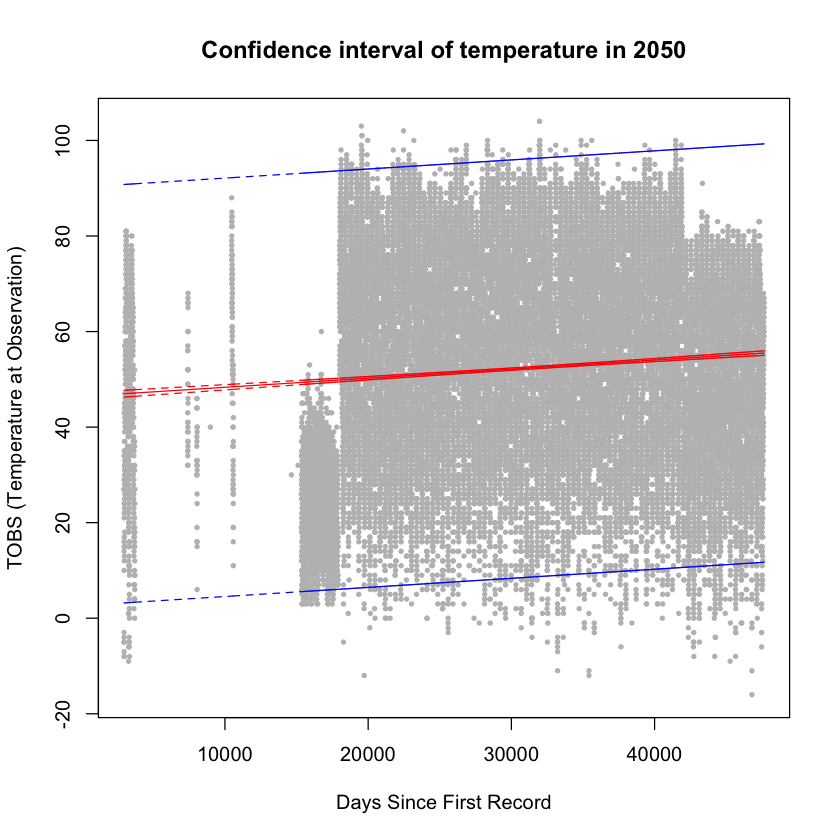

In [75]:
plot(
  x,
  y,
  pch = 16,
  cex = 0.6,
  col = "gray",
  xlab = "Days Since First Record",
  ylab = "TOBS (Temperature at Observation)",
  main = "Confidence interval of temperature in 2050"
)

points(x, Ey.hat_confidence[,1], typ="l", col="red")  # Regression line

points(x, Ey.hat_confidence[,2], typ="l", col="red", lty=2)
points(x, Ey.hat_confidence[,3], typ="l", col="red", lty=2)
points(x, Ey.hat_prediction[,2], typ="l", col="blue", lty=2)
points(x, Ey.hat_prediction[,3], typ="l", col="blue", lty=2)